In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from load_data import get_CIFAR10_data

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [2]:
class TwoLayerNet(object):

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        
        self.params = {}
        self.reg = reg
        self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
        self.params['W2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['b2'] = np.zeros(num_classes)

    def loss(self, X, y=None):
        scores = None

        out1, cache1 = affine_relu_forward(X, self.params['W1'], self.params['b1'])
        scores, cache2 = affine_relu_forward(out1, self.params['W2'], self.params['b2'])
        
        if y is None:
            return scores

        loss, grads = 0, {}

        loss, ds = softmax_loss(scores, y) 
        loss += (self.reg/2) * (np.sum(self.params['W1']**2, axis=None) + np.sum(self.params['W2']**2, axis=None))
        
        dout1, grads['W2'], grads['b2'] = affine_relu_backward(ds, cache2)
        grads['W2'] += (self.reg * self.params['W2'])
        
        _, grads['W1'], grads['b1'] = affine_relu_backward(dout1, cache1)
        grads['W1'] += (self.reg * self.params['W1'])
        
        return loss, grads

    
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout > 0
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution with standard deviation equal to  #
        # weight_scale and biases should be initialized to zero.                   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to one and shift      #
        # parameters should be initialized to zero.                                #
        ############################################################################
        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        for layer in range(self.num_layers):
        
            if layer == 0:
                self.params['W'+str(layer+1)] = weight_scale * np.random.randn(input_dim, hidden_dims[layer])
                self.params['b'+str(layer+1)] = np.zeros(hidden_dims[layer])
                
            elif layer == self.num_layers-1:
                self.params['W'+str(layer+1)] = weight_scale * np.random.randn(hidden_dims[layer-1], num_classes)
                self.params['b'+str(layer+1)] = np.zeros(num_classes)
                
            else:
                self.params['W'+str(layer+1)] = weight_scale * np.random.randn(hidden_dims[layer-1], hidden_dims[layer])
                self.params['b'+str(layer+1)] = np.zeros(hidden_dims[layer])
                
        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.use_batchnorm:
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.use_batchnorm:
            for bn_param in self.bn_params:
                bn_param['mode'] = mode

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        cache = [None for _ in range(self.num_layers+1)]
        out = [None for _ in range(self.num_layers+1)]
        out[0] = X.copy()
        
        for i in range(1, self.num_layers+1):
            if i == self.num_layers:
                out[i], cache[i] = affine_forward(out[i-1], self.params['W'+str(i)], self.params['b'+str(i)])
                scores = out[i].copy() 
            else:
                out[i], cache[i] = affine_relu_forward(out[i-1], self.params['W'+str(i)], self.params['b'+str(i)])

        # If test mode return early
        
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        pass
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        dout = [None for _ in range(self.num_layers+1)]
        loss, dout[-1] = softmax_loss(scores, y)
        loss += (self.reg/2) * np.sum([(np.sum(self.params['W'+str(i)]**2, axis=None)) for i in range(1, self.num_layers+1)])
        
        for i in range(self.num_layers, 0, -1):
            if i == self.num_layers:
                dout[i-1], grads['W'+str(i)], grads['b'+str(i)] = affine_backward(dout[i], cache[i])
                grads['W'+str(i)] += self.reg * self.params['W'+str(i)]
            else:
                dout[i-1], grads['W'+str(i)], grads['b'+str(i)] = affine_relu_backward(dout[i], cache[i])
                grads['W'+str(i)] += self.reg * self.params['W'+str(i)]
            
        return loss, grads


In [3]:
import os
import pickle as pickle
import optim

class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various optoins (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params


In [4]:
def affine_forward(x, w, b):

    dims = x.shape
    z = x.reshape(dims[0], np.prod(dims[1:]))
    out = np.matmul(z, w) + b
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):

    x, w, b = cache
    dims = x.shape
    z = x.reshape(dims[0], np.prod(dims[1:]))

    db = np.sum(dout, axis=0)
    dw = np.matmul(z.T, dout)
    dx = np.matmul(dout, w.T).reshape(dims)

    return dx, dw, db

In [5]:
def relu_forward(x):
    out = np.maximum(x, 0)
    cache = x
    return out, cache


def relu_backward(dout, cache):
    dx, x = None, cache
    mask = np.where(x > 0, 1, 0)
    dx = dout * mask
    return dx

In [6]:
def affine_relu_forward(x, w, b):
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

In [7]:
def svm_loss(x, y):
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


In [8]:
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [9]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[1.49834967, 1.70660132, 1.91485297],
                        [3.25553199, 3.5141327, 3.77273342]])

print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


In [10]:
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


In [13]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[0., 0., 0., 0., ],
                        [0., 0., 0.04545455, 0.13636364, ],
                        [0.22727273, 0.31818182, 0.40909091, 0.5, ]])

print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [152]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


In [19]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


In [20]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


In [21]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'
print(scores_diff)

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
5.1158512093252284e-08
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


In [43]:
model = TwoLayerNet(input_dim=np.prod(data['X_train'].shape[1:]), hidden_dim=130, num_classes=10,
                 weight_scale=1e-3, reg=0.25)
solver = Solver(model, data, update_rule = 'sgd',
                                optim_config = {'learning_rate' : 2*1e-3},
                                lr_decay = 0.9,
                                batch_size = 200,
                                num_epochs = 15,
                                verbose = True)
solver.train()

(Iteration 1 / 3675) loss: 2.351893
(Epoch 0 / 15) train acc: 0.146000; val_acc: 0.141000
(Iteration 11 / 3675) loss: 2.243761
(Iteration 21 / 3675) loss: 2.049390
(Iteration 31 / 3675) loss: 1.997756
(Iteration 41 / 3675) loss: 1.865817
(Iteration 51 / 3675) loss: 1.788824
(Iteration 61 / 3675) loss: 1.903360
(Iteration 71 / 3675) loss: 1.869771
(Iteration 81 / 3675) loss: 1.848987
(Iteration 91 / 3675) loss: 1.904173
(Iteration 101 / 3675) loss: 1.787439
(Iteration 111 / 3675) loss: 1.745916
(Iteration 121 / 3675) loss: 1.698218
(Iteration 131 / 3675) loss: 1.810078
(Iteration 141 / 3675) loss: 1.627652
(Iteration 151 / 3675) loss: 1.665735
(Iteration 161 / 3675) loss: 1.691446
(Iteration 171 / 3675) loss: 1.853730
(Iteration 181 / 3675) loss: 1.754143
(Iteration 191 / 3675) loss: 1.658447
(Iteration 201 / 3675) loss: 1.721535
(Iteration 211 / 3675) loss: 1.780028
(Iteration 221 / 3675) loss: 1.922050
(Iteration 231 / 3675) loss: 1.599864
(Iteration 241 / 3675) loss: 1.688399
(Epoch 

(Iteration 2021 / 3675) loss: 1.268788
(Iteration 2031 / 3675) loss: 1.236433
(Iteration 2041 / 3675) loss: 1.395445
(Iteration 2051 / 3675) loss: 1.193660
(Iteration 2061 / 3675) loss: 1.219805
(Iteration 2071 / 3675) loss: 1.309085
(Iteration 2081 / 3675) loss: 1.366415
(Iteration 2091 / 3675) loss: 1.352740
(Iteration 2101 / 3675) loss: 1.442257
(Iteration 2111 / 3675) loss: 1.270889
(Iteration 2121 / 3675) loss: 1.280163
(Iteration 2131 / 3675) loss: 1.311145
(Iteration 2141 / 3675) loss: 1.354167
(Iteration 2151 / 3675) loss: 1.267727
(Iteration 2161 / 3675) loss: 1.214343
(Iteration 2171 / 3675) loss: 1.232824
(Iteration 2181 / 3675) loss: 1.337012
(Iteration 2191 / 3675) loss: 1.336130
(Iteration 2201 / 3675) loss: 1.372029
(Epoch 9 / 15) train acc: 0.586000; val_acc: 0.510000
(Iteration 2211 / 3675) loss: 1.378749
(Iteration 2221 / 3675) loss: 1.348969
(Iteration 2231 / 3675) loss: 1.234285
(Iteration 2241 / 3675) loss: 1.373944
(Iteration 2251 / 3675) loss: 1.378749
(Iteration

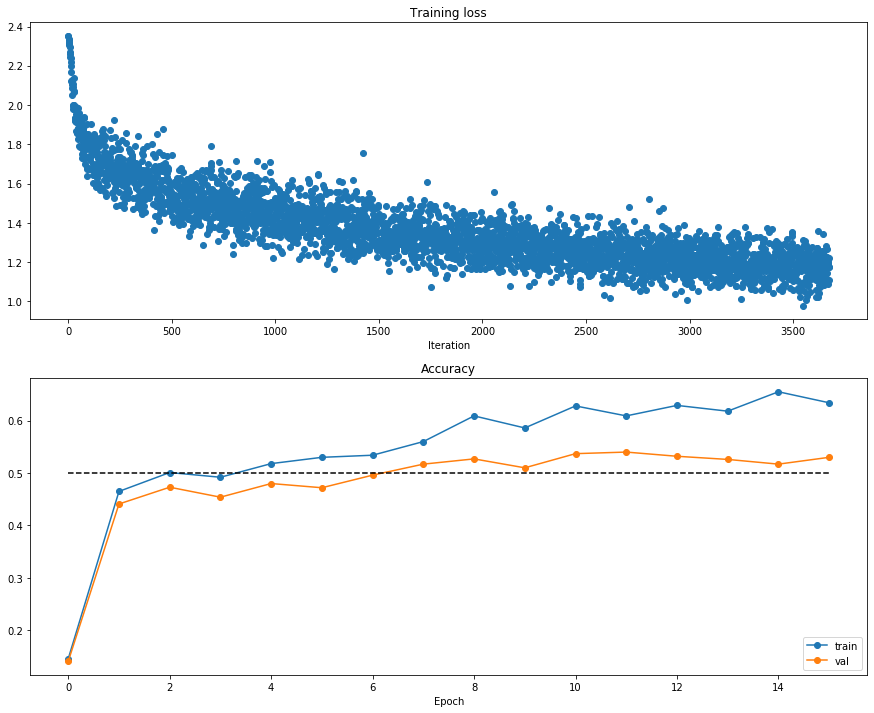

In [44]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [11]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.86e-09
W2 relative error: 3.52e-08
W3 relative error: 1.32e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


(Iteration 1 / 40) loss: 280.715356
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.125000
(Epoch 1 / 20) train acc: 0.340000; val_acc: 0.091000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.124000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.143000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.135000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.153000
(Iteration 11 / 40) loss: 12.165480
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.157000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.154000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.149000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.149000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.156000
(Iteration 21 / 40) loss: 0.000000
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.156000
(Iteration 31 / 40) los

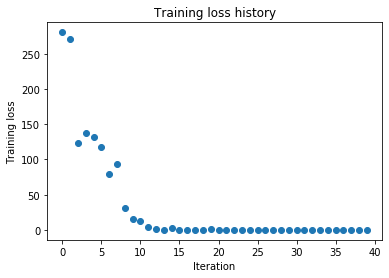

In [17]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Iteration 1 / 40) loss: 188.336558
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.076000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.123000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.129000
(Epoch 3 / 20) train acc: 0.580000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.131000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.143000
(Iteration 11 / 40) loss: 2.637615
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.153000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.151000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.139000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.135000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.136000
(Iteration 21 / 40) loss: 2.594993
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.136000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.127000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.134000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.138000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.137000
(Iteration 31 / 40) loss

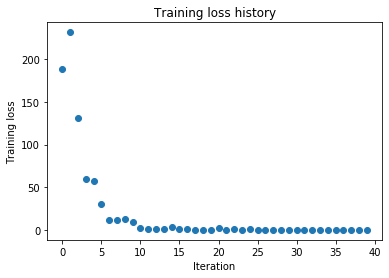

In [34]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-1
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [9]:
from optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 2.598279
(Epoch 0 / 5) train acc: 0.099000; val_acc: 0.125000
(Iteration 11 / 200) loss: 2.241485
(Iteration 21 / 200) loss: 2.092932
(Iteration 31 / 200) loss: 2.096806
(Epoch 1 / 5) train acc: 0.254000; val_acc: 0.253000
(Iteration 41 / 200) loss: 2.087498
(Iteration 51 / 200) loss: 2.055535
(Iteration 61 / 200) loss: 2.043214
(Iteration 71 / 200) loss: 1.894018
(Epoch 2 / 5) train acc: 0.316000; val_acc: 0.284000
(Iteration 81 / 200) loss: 1.950842
(Iteration 91 / 200) loss: 1.715782
(Iteration 101 / 200) loss: 1.909297
(Iteration 111 / 200) loss: 1.999764
(Epoch 3 / 5) train acc: 0.381000; val_acc: 0.311000
(Iteration 121 / 200) loss: 1.781105
(Iteration 131 / 200) loss: 1.743964
(Iteration 141 / 200) loss: 1.649018
(Iteration 151 / 200) loss: 1.653303
(Epoch 4 / 5) train acc: 0.363000; val_acc: 0.292000
(Iteration 161 / 200) loss: 1.774370
(Iteration 171 / 200) loss: 1.773407
(Iteration 181 / 200) loss: 1.698118
(Iteration 191 / 200) los

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

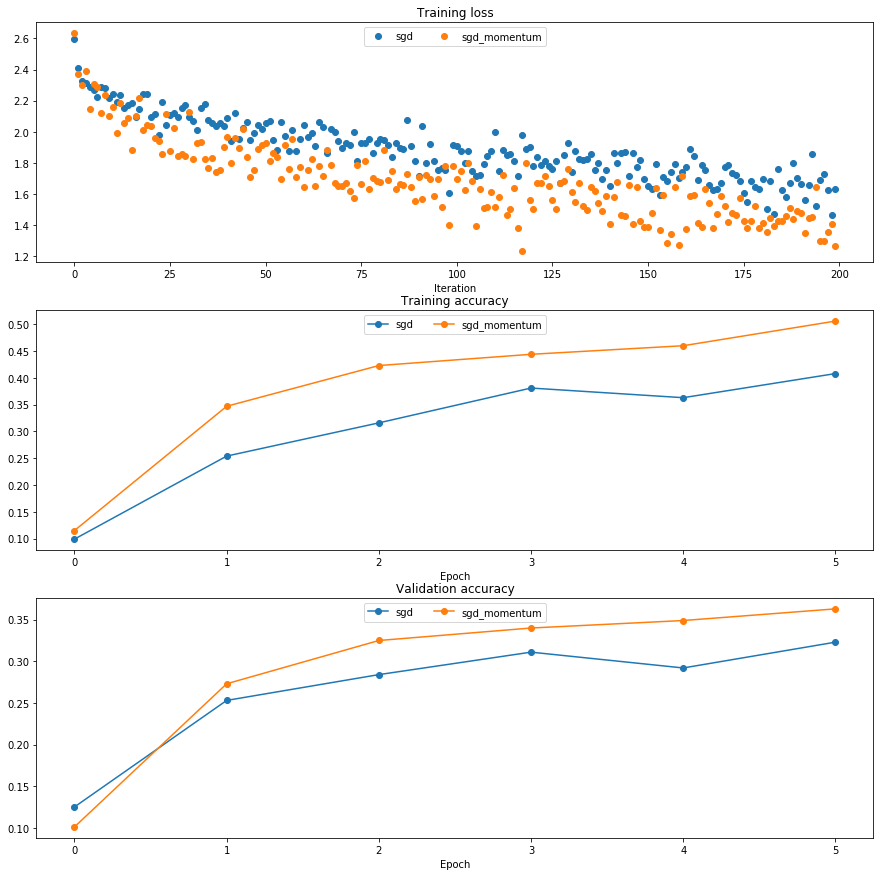

In [14]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

In [2]:
from optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [2]:
from optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


running with  adam
(Iteration 1 / 200) loss: 2.366713
(Epoch 0 / 5) train acc: 0.117000; val_acc: 0.109000
(Iteration 11 / 200) loss: 2.219153
(Iteration 21 / 200) loss: 1.948938
(Iteration 31 / 200) loss: 1.862095
(Epoch 1 / 5) train acc: 0.360000; val_acc: 0.335000
(Iteration 41 / 200) loss: 1.849094
(Iteration 51 / 200) loss: 1.637795
(Iteration 61 / 200) loss: 1.626097
(Iteration 71 / 200) loss: 1.628595
(Epoch 2 / 5) train acc: 0.448000; val_acc: 0.355000
(Iteration 81 / 200) loss: 1.622041
(Iteration 91 / 200) loss: 1.435141
(Iteration 101 / 200) loss: 1.472767
(Iteration 111 / 200) loss: 1.449099
(Epoch 3 / 5) train acc: 0.445000; val_acc: 0.338000
(Iteration 121 / 200) loss: 1.532784
(Iteration 131 / 200) loss: 1.546450
(Iteration 141 / 200) loss: 1.340189
(Iteration 151 / 200) loss: 1.226996
(Epoch 4 / 5) train acc: 0.577000; val_acc: 0.373000
(Iteration 161 / 200) loss: 1.460876
(Iteration 171 / 200) loss: 1.262599
(Iteration 181 / 200) loss: 1.130056
(Iteration 191 / 200) lo

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

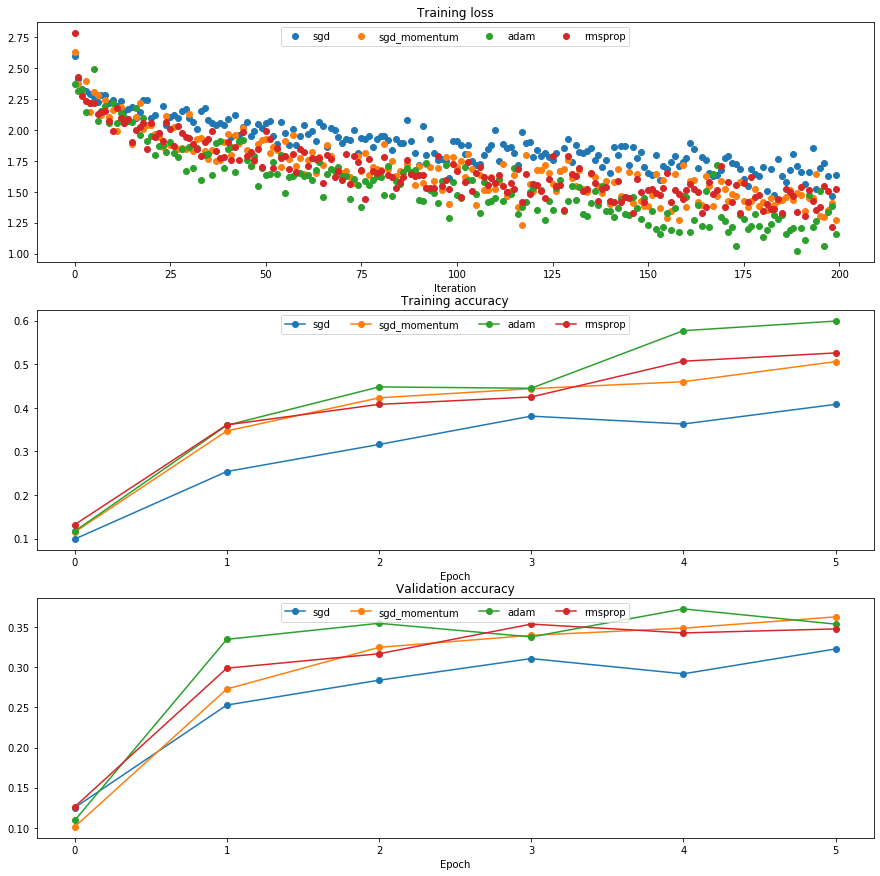

In [15]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

In [33]:
N, D = data['X_train'].shape[0], np.prod(data['X_train'].shape[1:])
hidden_dims = [100, 100, 100]
FCN = FullyConnectedNet(hidden_dims, input_dim=D, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.01,
                 weight_scale=1e-2, dtype=np.float32, seed=None)

solver = Solver(FCN, data,
                update_rule = 'adam',
                lr_decay = 0.95,
                optim_config = {
                   'learning_rate' : 1e-3,
                   'beta1' : 0.9,
                   'beta2' : 0.99,
                   't' : 0,
                   'm' : 0,
                   'v' : 0,
                   'epsilon' : 1e-8
               },
               batch_size = 500,
               num_epochs = 20,
               verbose = True)
solver.train()

(Iteration 1 / 1960) loss: 2.465778
(Epoch 0 / 20) train acc: 0.149000; val_acc: 0.149000
(Iteration 11 / 1960) loss: 2.067237
(Iteration 21 / 1960) loss: 1.944705
(Iteration 31 / 1960) loss: 1.843886
(Iteration 41 / 1960) loss: 1.837738
(Iteration 51 / 1960) loss: 1.733711
(Iteration 61 / 1960) loss: 1.724924
(Iteration 71 / 1960) loss: 1.742288
(Iteration 81 / 1960) loss: 1.660941
(Iteration 91 / 1960) loss: 1.643625
(Epoch 1 / 20) train acc: 0.431000; val_acc: 0.444000
(Iteration 101 / 1960) loss: 1.711867
(Iteration 111 / 1960) loss: 1.677788
(Iteration 121 / 1960) loss: 1.647013
(Iteration 131 / 1960) loss: 1.606176
(Iteration 141 / 1960) loss: 1.590339
(Iteration 151 / 1960) loss: 1.584668
(Iteration 161 / 1960) loss: 1.674045
(Iteration 171 / 1960) loss: 1.551220
(Iteration 181 / 1960) loss: 1.573344
(Iteration 191 / 1960) loss: 1.599969
(Epoch 2 / 20) train acc: 0.482000; val_acc: 0.483000
(Iteration 201 / 1960) loss: 1.518068
(Iteration 211 / 1960) loss: 1.530031
(Iteration 22

(Iteration 1871 / 1960) loss: 1.080259
(Iteration 1881 / 1960) loss: 1.076486
(Iteration 1891 / 1960) loss: 1.092728
(Iteration 1901 / 1960) loss: 1.102870
(Iteration 1911 / 1960) loss: 1.096287
(Iteration 1921 / 1960) loss: 1.118047
(Iteration 1931 / 1960) loss: 1.082114
(Iteration 1941 / 1960) loss: 1.106523
(Iteration 1951 / 1960) loss: 1.038491
(Epoch 20 / 20) train acc: 0.686000; val_acc: 0.550000


In [34]:
y_test_pred = np.argmax(FCN.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(FCN.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.558
Test set accuracy:  0.55
